Distribution of the fractional drug release values for the 17-feature liposome datasets.

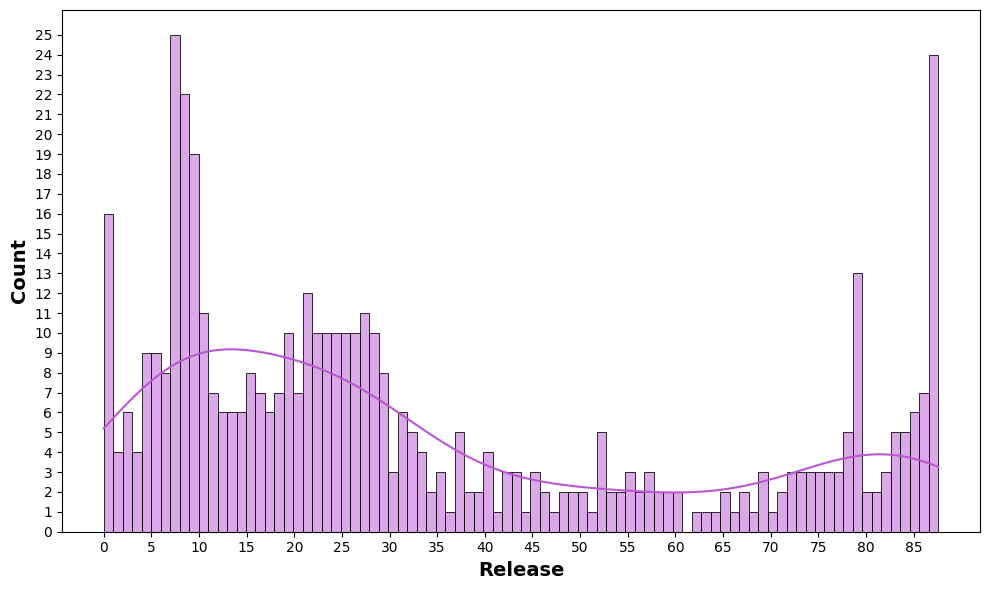

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_excel("17_input_features.xlsx")
f, boxplot = plt.subplots(figsize=(10,6))
sns.histplot(df['Release'], binwidth=1, color='mediumorchid', kde=True)
plt.ylabel("Count", fontsize=14, color='black',  weight="bold")
plt.xlabel("Release", fontsize=14, color='black', weight="bold")
plt.xticks(np.arange(0, 90,5)) 
plt.yticks(np.arange(0,26))
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.tight_layout()
plt.savefig('ArticleFigures/HistPlot1', dpi=600, format = 'png', transparent=True, bbox_inches='tight')
plt.show()

Distribution of drug-phospholipid groups in the 17-feature dataset

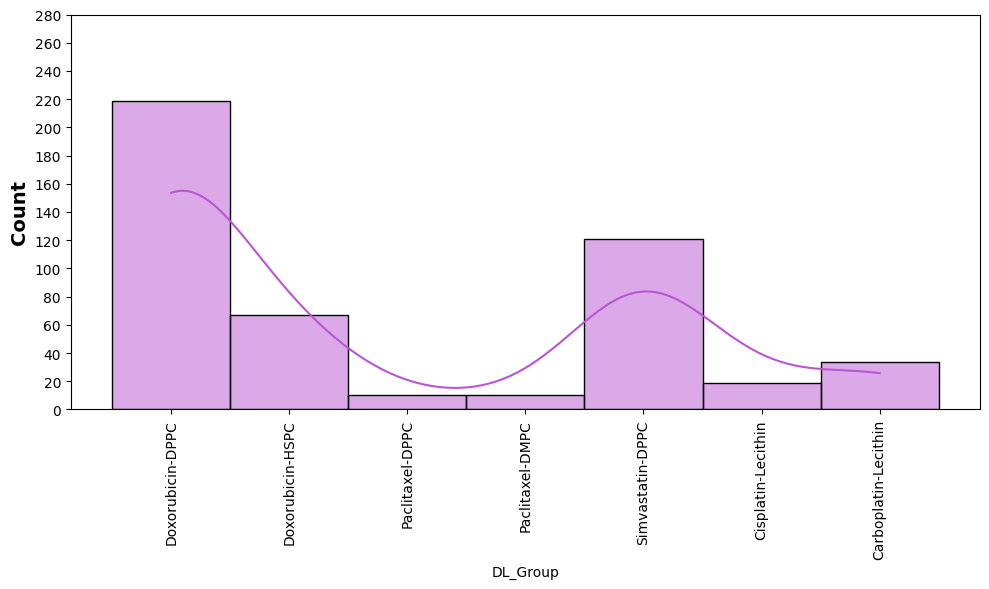

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_excel("17_input_features.xlsx")
f, boxplot = plt.subplots(figsize=(10,6))
sns.histplot(df["DL_Group"], binwidth=1, color='mediumorchid', kde=True)
plt.ylabel("Count", fontsize=14, color='black',  weight="bold")
plt.yticks(np.arange(0,300,20))
plt.yticks(fontsize=10)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.savefig('ArticleFigures/HistPlot2', dpi=600, format = 'png', transparent=True, bbox_inches='tight')
plt.show()

Primary Model Training 

Data Splitting Using Nested Cross-Validation

Development and Evaluation of NGBRegressor Model

In [15]:
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from ngboost import NGBRegressor
from ngboost.distns import Normal
from ngboost.scores import MLE
from sklearn.tree import DecisionTreeRegressor

# Load the dataset
file_path = '17_input_features.xlsx'
df = pd.read_excel(file_path)

# Define X, y, and groups
X = df.drop(columns=['Experimental_index', 'DL_Group', 'Release'])
y = df['Release']
groups = df['Experimental_index']

# Apply StandardScaler to the entire dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the models and their parameter grids
models = {
    "NGBRegressor": {
        'model': NGBRegressor(Dist=Normal, Score=MLE),
        'param_grid': {
            'n_estimators': [100, 200, 300, 400, 500, 600, 800],
            'learning_rate': [0.1, 0.01, 0.001],
            'minibatch_frac': [1.0, 0.8, 0.5],
            'col_sample': [1, 0.8, 0.5],
            'Base': [DecisionTreeRegressor(criterion='squared_error', max_depth=d) for d in [2, 4, 8, 12, 16, 32]]
        }
    },
}

# Initialize results storage
results = []

# Outer loop: GroupShuffleSplit
outer_split = GroupShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

for train_idx, test_idx in outer_split.split(X_scaled, y, groups):
    X_train_outer, X_test_outer = X_scaled[train_idx], X_scaled[test_idx]
    y_train_outer, y_test_outer = y.iloc[train_idx], y.iloc[test_idx]
    groups_train_outer = groups.iloc[train_idx]

    for model_name, model_info in models.items():
        model = model_info['model']
        param_grid = model_info['param_grid']

        # Inner loop: GroupKFold
        inner_split = GroupKFold(n_splits=10)

        randomized_search = RandomizedSearchCV(
            model,
            param_distributions=param_grid,
            n_iter=30,
            scoring='neg_mean_absolute_error',
            cv=inner_split.split(X_train_outer, y_train_outer, groups_train_outer),
            random_state=42,
            n_jobs=-1
        )

        randomized_search.fit(X_train_outer, y_train_outer)

        best_model = randomized_search.best_estimator_
        y_pred = best_model.predict(X_test_outer)
        mae = mean_absolute_error(y_test_outer, y_pred)
        abs_errors = np.abs(y_test_outer - y_pred)

        results.append({
            'model': model_name,
            'best_params': randomized_search.best_params_,
            'mean_absolute_error': mae,
            'absolute_errors': abs_errors,
            'best_model': best_model
        })

# Save the best model
best_model_info = min(results, key=lambda x: x['mean_absolute_error'])
with open('best_NGBRegressor_17_feature.pkl', 'wb') as f:
    pickle.dump(best_model_info['best_model'], f)

# Save results to an Excel file
results_df = pd.DataFrame(results)
results_df.to_excel('best_NGBRegressor_17_feature.xlsx', index=False)

# Print all results and the best results with best hyperparameters
print("All results:")
print(results_df)
print(f"The best model is {best_model_info['model']} with a mean absolute error of {best_model_info['mean_absolute_error']}.")
print(f"Best hyperparameters: {best_model_info['best_params']}")


[iter 0] loss=4.8432 val_loss=0.0000 scale=2.0000 norm=54.2717
[iter 100] loss=-17.1906 val_loss=0.0000 scale=2.0000 norm=0.1178
== Quitting at iteration / GRAD 162
[iter 0] loss=4.8269 val_loss=0.0000 scale=2.0000 norm=53.7344
[iter 100] loss=-0.5496 val_loss=0.0000 scale=1.0000 norm=0.4061
[iter 200] loss=-1.3233 val_loss=0.0000 scale=1.0000 norm=0.3253
[iter 300] loss=-1.7621 val_loss=0.0000 scale=1.0000 norm=0.2923
[iter 400] loss=-2.2868 val_loss=0.0000 scale=0.1250 norm=0.0301
[iter 0] loss=4.7614 val_loss=0.0000 scale=1.0000 norm=24.6688
[iter 100] loss=3.6744 val_loss=0.0000 scale=2.0000 norm=9.6721
[iter 200] loss=2.7290 val_loss=0.0000 scale=2.0000 norm=2.6441
[iter 0] loss=4.4734 val_loss=0.0000 scale=2.0000 norm=32.8294
[iter 100] loss=3.2985 val_loss=0.0000 scale=2.0000 norm=6.3125
[iter 200] loss=2.3036 val_loss=0.0000 scale=2.0000 norm=1.6312
[iter 300] loss=1.1153 val_loss=0.0000 scale=2.0000 norm=1.0328
[iter 400] loss=-0.7915 val_loss=0.0000 scale=4.0000 norm=1.9552
[

c:\Users\Afra\AppData\Local\Programs\Python\Python39\lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Afra\AppData\Local\Programs\Python\Python39\lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 200] loss=-10.4184 val_loss=0.0000 scale=2.0000 norm=0.7733
[iter 300] loss=-14.8651 val_loss=0.0000 scale=1.0000 norm=0.3555
[iter 400] loss=-16.4152 val_loss=0.0000 scale=0.5000 norm=0.1121
[iter 0] loss=4.5059 val_loss=0.0000 scale=2.0000 norm=34.1941
[iter 100] loss=-5.7754 val_loss=0.0000 scale=2.0000 norm=0.7691
[iter 200] loss=-10.5582 val_loss=0.0000 scale=2.0000 norm=0.9420


c:\Users\Afra\AppData\Local\Programs\Python\Python39\lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Afra\AppData\Local\Programs\Python\Python39\lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 300] loss=-14.2701 val_loss=0.0000 scale=2.0000 norm=0.6964
[iter 400] loss=-15.8604 val_loss=0.0000 scale=1.0000 norm=0.2499
[iter 0] loss=4.8206 val_loss=0.0000 scale=2.0000 norm=53.6399
[iter 100] loss=3.6563 val_loss=0.0000 scale=2.0000 norm=8.2249
[iter 200] loss=2.6528 val_loss=0.0000 scale=2.0000 norm=1.7010
[iter 300] loss=0.9567 val_loss=0.0000 scale=4.0000 norm=2.0056
[iter 400] loss=-1.2190 val_loss=0.0000 scale=4.0000 norm=1.9940
[iter 500] loss=-3.1956 val_loss=0.0000 scale=4.0000 norm=1.9624
[iter 0] loss=4.4292 val_loss=0.0000 scale=2.0000 norm=32.4192
[iter 100] loss=-5.7939 val_loss=0.0000 scale=2.0000 norm=0.7446
[iter 200] loss=-10.8018 val_loss=0.0000 scale=2.0000 norm=0.7505
[iter 300] loss=-15.2849 val_loss=0.0000 scale=1.0000 norm=0.3405
[iter 0] loss=4.7640 val_loss=0.0000 scale=2.0000 norm=47.0463
[iter 100] loss=-17.2830 val_loss=0.0000 scale=1.0000 norm=0.1180
[iter 200] loss=-17.3977 val_loss=0.0000 scale=0.1250 norm=0.0016
[iter 300] loss=-17.4070 val

Feature Engineering Techniques: Applying Agglomerative Hierarchical Clustering

Heatmap of the absolute Spearman’s Rank correlation between  the initial 17 input features

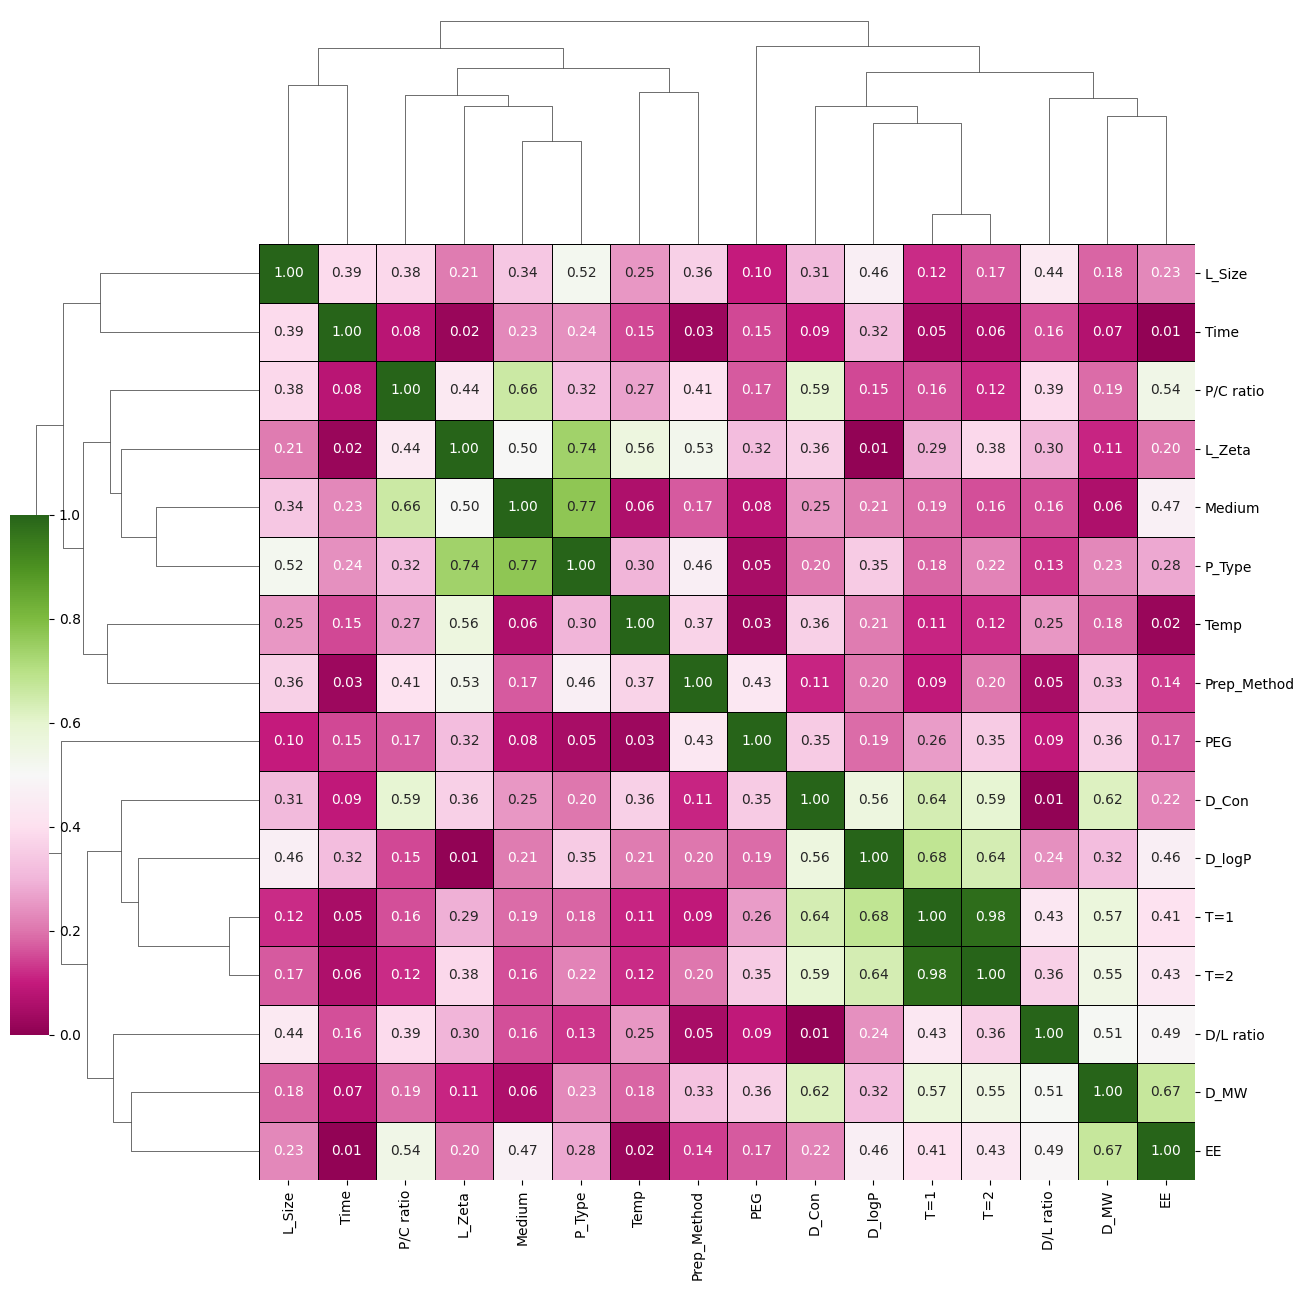

In [17]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
datafile = pd.read_excel("17_input_features.xlsx")
X = datafile.drop(columns=['Experimental_index', 'DL_Group','Release'])
X = X.loc[:, (X != X.iloc[0]).any()]
correlation = X.corr(method='spearman')
sns.clustermap(round(np.abs(correlation),2),vmin=0, vmax=1,  annot=True, figsize=(13,13),  cbar=True, cmap='PiYG'
               , cbar_pos=(0, .2, .03, .4),  fmt=".2f",   linecolor='black', linewidths=0.5)
plt.savefig('ArticleFigures/clustermap', dpi=600, format = 'png', transparent=True, bbox_inches='tight')
plt.show()


delete T=1 so 16 features.

In [18]:
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from ngboost import NGBRegressor
from ngboost.distns import Normal
from ngboost.scores import MLE
from sklearn.tree import DecisionTreeRegressor

# Load the dataset
file_path = '16_input_features.xlsx'
df = pd.read_excel(file_path)

# Define X, y, and groups
X = df.drop(columns=['Experimental_index', 'DL_Group', 'Release'])
y = df['Release']
groups = df['Experimental_index']

# Apply StandardScaler to the entire dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



# Define the models and their parameter grids
models = {
    "NGBRegressor": {
        'model': NGBRegressor(Dist=Normal, Score=MLE),
        'param_grid': {
            'n_estimators': [100, 200, 300, 400, 500, 600, 800],
            'learning_rate': [0.1, 0.01, 0.001],
            'minibatch_frac': [1.0, 0.8, 0.5],
            'col_sample': [1, 0.8, 0.5],
            'Base': [DecisionTreeRegressor(criterion='squared_error', max_depth=d) for d in [2, 4, 8, 12, 16, 32]]
        }
    },
}

# Initialize results storage
results = []

# Outer loop: GroupShuffleSplit
outer_split = GroupShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

for train_idx, test_idx in outer_split.split(X_scaled, y, groups):
    X_train_outer, X_test_outer = X_scaled[train_idx], X_scaled[test_idx]
    y_train_outer, y_test_outer = y.iloc[train_idx], y.iloc[test_idx]
    groups_train_outer = groups.iloc[train_idx]

    for model_name, model_info in models.items():
        model = model_info['model']
        param_grid = model_info['param_grid']

        # Inner loop: GroupKFold
        inner_split = GroupKFold(n_splits=10)

        randomized_search = RandomizedSearchCV(
            model,
            param_distributions=param_grid,
            n_iter=30,
            scoring='neg_mean_absolute_error',
            cv=inner_split.split(X_train_outer, y_train_outer, groups_train_outer),
            random_state=42,
            n_jobs=-1
        )

        randomized_search.fit(X_train_outer, y_train_outer)

        best_model = randomized_search.best_estimator_
        y_pred = best_model.predict(X_test_outer)
        mae = mean_absolute_error(y_test_outer, y_pred)
        abs_errors = np.abs(y_test_outer - y_pred)

        results.append({
            'model': model_name,
            'best_params': randomized_search.best_params_,
            'mean_absolute_error': mae,
            'absolute_errors': abs_errors,
            'best_model': best_model
        })

# Save the best model
best_model_info = min(results, key=lambda x: x['mean_absolute_error'])
with open('best_NGBRegressor_16_feature.pkl', 'wb') as f:
    pickle.dump(best_model_info['best_model'], f)

# Save results to an Excel file
results_df = pd.DataFrame(results)
results_df.to_excel('best_NGBRegressor_16_feature.xlsx', index=False)

# Print all results and the best results with best hyperparameters
print("All results:")
print(results_df)
print(f"The best model is {best_model_info['model']} with a mean absolute error of {best_model_info['mean_absolute_error']}.")
print(f"Best hyperparameters: {best_model_info['best_params']}")


[iter 0] loss=4.8479 val_loss=0.0000 scale=2.0000 norm=55.1060
[iter 100] loss=-1.3855 val_loss=0.0000 scale=1.0000 norm=0.3309
[iter 200] loss=-2.0837 val_loss=0.0000 scale=0.5000 norm=0.1463
[iter 300] loss=-2.5057 val_loss=0.0000 scale=0.1250 norm=0.0336
[iter 400] loss=-2.9479 val_loss=0.0000 scale=0.5000 norm=0.1193
[iter 0] loss=4.8310 val_loss=0.0000 scale=2.0000 norm=53.7152
[iter 100] loss=0.1554 val_loss=0.0000 scale=0.5000 norm=0.2568
[iter 200] loss=-0.3111 val_loss=0.0000 scale=1.0000 norm=0.4043
[iter 300] loss=-0.6206 val_loss=0.0000 scale=1.0000 norm=0.3490
[iter 400] loss=-0.9613 val_loss=0.0000 scale=1.0000 norm=0.3176
[iter 500] loss=-1.1999 val_loss=0.0000 scale=1.0000 norm=0.3093
[iter 600] loss=-1.4547 val_loss=0.0000 scale=0.5000 norm=0.1441
[iter 700] loss=-1.6277 val_loss=0.0000 scale=0.5000 norm=0.1337
[iter 0] loss=4.7603 val_loss=0.0000 scale=1.0000 norm=24.5438
[iter 100] loss=0.5407 val_loss=0.0000 scale=1.0000 norm=0.6168
[iter 200] loss=0.0204 val_loss=0

c:\Users\Afra\AppData\Local\Programs\Python\Python39\lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 200] loss=-10.6806 val_loss=0.0000 scale=2.0000 norm=0.7952


c:\Users\Afra\AppData\Local\Programs\Python\Python39\lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 300] loss=-14.8149 val_loss=0.0000 scale=1.0000 norm=0.3313
[iter 400] loss=-16.0572 val_loss=0.0000 scale=2.0000 norm=0.4214
[iter 0] loss=4.4766 val_loss=0.0000 scale=2.0000 norm=33.2087
[iter 100] loss=3.2762 val_loss=0.0000 scale=2.0000 norm=5.7603
[iter 200] loss=2.2921 val_loss=0.0000 scale=2.0000 norm=1.5897
[iter 300] loss=1.0090 val_loss=0.0000 scale=2.0000 norm=1.0392
[iter 400] loss=-0.2281 val_loss=0.0000 scale=2.0000 norm=0.9698
[iter 500] loss=-1.3646 val_loss=0.0000 scale=4.0000 norm=1.8262
[iter 0] loss=4.8206 val_loss=0.0000 scale=2.0000 norm=53.6399
[iter 100] loss=3.6780 val_loss=0.0000 scale=2.0000 norm=8.8217
[iter 200] loss=2.6784 val_loss=0.0000 scale=2.0000 norm=1.9418
[iter 300] loss=1.4122 val_loss=0.0000 scale=2.0000 norm=1.0606
[iter 400] loss=-0.0147 val_loss=0.0000 scale=4.0000 norm=1.9895
[iter 500] loss=-1.9959 val_loss=0.0000 scale=4.0000 norm=1.9757
[iter 0] loss=4.4689 val_loss=0.0000 scale=2.0000 norm=33.2109
[iter 100] loss=-5.4864 val_loss=0.

c:\Users\Afra\AppData\Local\Programs\Python\Python39\lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Afra\AppData\Local\Programs\Python\Python39\lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Afra\AppData\Local\Programs\Python\Python39\lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Afra\AppData\Local\Programs\Python\Python39\lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Afra\AppData\Local\Programs\Python\Python39\lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Afra\AppData\Local\Programs\Python\Python39\lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow en

[iter 200] loss=-7.9777 val_loss=0.0000 scale=2.0000 norm=0.7477


c:\Users\Afra\AppData\Local\Programs\Python\Python39\lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 300] loss=-12.4528 val_loss=0.0000 scale=2.0000 norm=0.8253


c:\Users\Afra\AppData\Local\Programs\Python\Python39\lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Afra\AppData\Local\Programs\Python\Python39\lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Afra\AppData\Local\Programs\Python\Python39\lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Afra\AppData\Local\Programs\Python\Python39\lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Afra\AppData\Local\Programs\Python\Python39\lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Afra\AppData\Local\Programs\Python\Python39\lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow

[iter 0] loss=4.7600 val_loss=0.0000 scale=2.0000 norm=46.4241
[iter 100] loss=-17.2547 val_loss=0.0000 scale=0.5000 norm=0.0442
[iter 200] loss=-17.3042 val_loss=0.0000 scale=0.1250 norm=0.0014
[iter 300] loss=-17.3816 val_loss=0.0000 scale=0.0078 norm=0.0001
[iter 400] loss=-17.3493 val_loss=0.0000 scale=0.0156 norm=0.0001
[iter 500] loss=-17.2702 val_loss=0.0000 scale=0.5000 norm=0.0016
All results:
          model                                        best_params  \
0  NGBRegressor  {'n_estimators': 500, 'minibatch_frac': 0.5, '...   
1  NGBRegressor  {'n_estimators': 800, 'minibatch_frac': 0.8, '...   
2  NGBRegressor  {'n_estimators': 800, 'minibatch_frac': 0.8, '...   
3  NGBRegressor  {'n_estimators': 800, 'minibatch_frac': 1.0, '...   
4  NGBRegressor  {'n_estimators': 800, 'minibatch_frac': 0.8, '...   
5  NGBRegressor  {'n_estimators': 500, 'minibatch_frac': 0.5, '...   
6  NGBRegressor  {'n_estimators': 600, 'minibatch_frac': 1.0, '...   
7  NGBRegressor  {'n_estimators': 

Model Interpretation: Using the TreeSHAP Package for Insights

In [1]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import shap
import pickle
import matplotlib.pyplot as plt

In [2]:
datafile = "17_input_features.xlsx"

df = pd.read_excel(datafile)

with open('best_NGBRegressor_17_feature.pkl', 'rb') as file:  
    NGBRegressor_model = pickle.load(file)

X = df.drop(['Experimental_index','DL_Group','Release'],axis='columns')
y = df['Release']

In [3]:
stdScale = StandardScaler().fit(X)
X_scale=stdScale.transform(X)

In [6]:
NGBRegressor_model

NGBRegressor(Base=DecisionTreeRegressor(max_depth=4), col_sample=0.8,
             minibatch_frac=0.5, n_estimators=300,
             random_state=RandomState(MT19937) at 0x129B318D840)

In [7]:
bestModel = NGBRegressor_model
bestModel.fit(X, y)
explainer = shap.TreeExplainer(NGBRegressor_model)
shap_values = explainer(X)

[iter 0] loss=4.7576 val_loss=0.0000 scale=1.0000 norm=23.6978
[iter 100] loss=3.6017 val_loss=0.0000 scale=2.0000 norm=8.2031
[iter 200] loss=2.6447 val_loss=0.0000 scale=2.0000 norm=2.3201


c:\Users\Afra\AppData\Local\Programs\Python\Python39\lib\site-packages\shap\explainers\_tree.py:1185: UserWarning: Translating model_output="raw" to model_output=0 for the 0-th parameter in the distribution. Use model_output=0 directly to avoid this warning.
  warnings.warn("Translating model_output=\"raw\" to model_output=0 for the 0-th parameter in the distribution. Use model_output=0 directly to avoid this warning.")


In [8]:
shap_values

.values =
array([[-4.66116843e-02, -1.44066621e-03,  4.27386254e-02, ...,
         3.51495792e+00,  1.80480228e+00, -3.87577151e+01],
       [-5.74847741e-02,  1.23910221e-01,  4.93079097e-02, ...,
         4.60750228e+00,  2.62441950e+00, -3.11569313e+01],
       [-5.86696563e-02,  1.99503381e-01,  6.63575559e-02, ...,
         5.14018910e+00,  2.92786365e+00, -2.64258006e+01],
       ...,
       [-3.15578821e-03, -2.34763747e-01,  1.47684682e-01, ...,
        -8.91461082e+00, -9.59460224e+00,  3.04930838e+00],
       [-6.48452841e-03, -2.88118082e-01,  1.52554363e-01, ...,
        -8.93240472e+00, -9.43656809e+00,  5.31972681e+00],
       [-7.06413853e-02, -2.12861133e-01,  1.94789344e-01, ...,
        -8.58539648e+00, -9.04833786e+00,  1.10226325e+01]])

.base_values =
array([33.92672677, 33.92672677, 33.92672677, 33.92672677, 33.92672677,
       33.92672677, 33.92672677, 33.92672677, 33.92672677, 33.92672677,
       33.92672677, 33.92672677, 33.92672677, 33.92672677, 33.92672677,
 

In [9]:
shap_values_dataframe = pd.DataFrame(shap_values.values, columns=X.columns)

In [11]:
X.head()

,D_MW,D_Con,D_logP,L_Size,L_Zeta,EE,PH,Temp,D/L ratio,PEG,Medium,P_Type,Prep_Method,P/C ratio,T=1,T=2,Time
0,543.5,0.2,1.27,242.1,35.1,52.5,7.4,48,4.2,1,1,1,1,0.0,15.0,21.67,0.0
1,543.5,0.2,1.27,242.1,35.1,52.5,7.4,48,4.2,1,1,1,1,0.0,15.0,21.67,0.6
2,543.5,0.2,1.27,242.1,35.1,52.5,7.4,48,4.2,1,1,1,1,0.0,15.0,21.67,1.2
3,543.5,0.2,1.27,242.1,35.1,52.5,7.4,48,4.2,1,1,1,1,0.0,15.0,21.67,1.8
4,543.5,0.2,1.27,242.1,35.1,52.5,7.4,48,4.2,1,1,1,1,0.0,15.0,21.67,2.4


In [12]:
shap_values_dataframe.head()

,D_MW,D_Con,D_logP,L_Size,L_Zeta,EE,PH,Temp,D/L ratio,PEG,Medium,P_Type,Prep_Method,P/C ratio,T=1,T=2,Time
0,-0.046612,-0.001441,0.042739,-0.384914,-0.142265,-0.284820,0.0,0.244933,-0.094442,0.004783,0.003027,0.134532,0.007796,0.241432,3.514958,1.804802,-38.757715
1,-0.057485,0.123910,0.049308,-0.377335,-0.102802,-0.282812,0.0,0.253436,-0.172139,0.005629,0.004005,0.147704,0.004437,0.322216,4.607502,2.624419,-31.156931
2,-0.058670,0.199503,0.066358,-0.376450,-0.032254,-0.288566,0.0,0.253436,-0.315637,0.006377,0.004005,0.170382,0.004437,0.377224,5.140189,2.927864,-26.425801
3,-0.065569,0.211113,0.084292,-0.418136,0.023189,-0.326214,0.0,0.347082,-0.262409,0.006754,0.004005,0.188889,0.004437,0.397956,5.433311,3.158472,-23.134656
4,-0.065569,0.249508,0.120618,-0.425522,0.070916,-0.327583,0.0,0.347082,-0.294715,0.006754,0.004005,0.218734,0.004437,0.403978,5.794051,3.069170,-20.210521


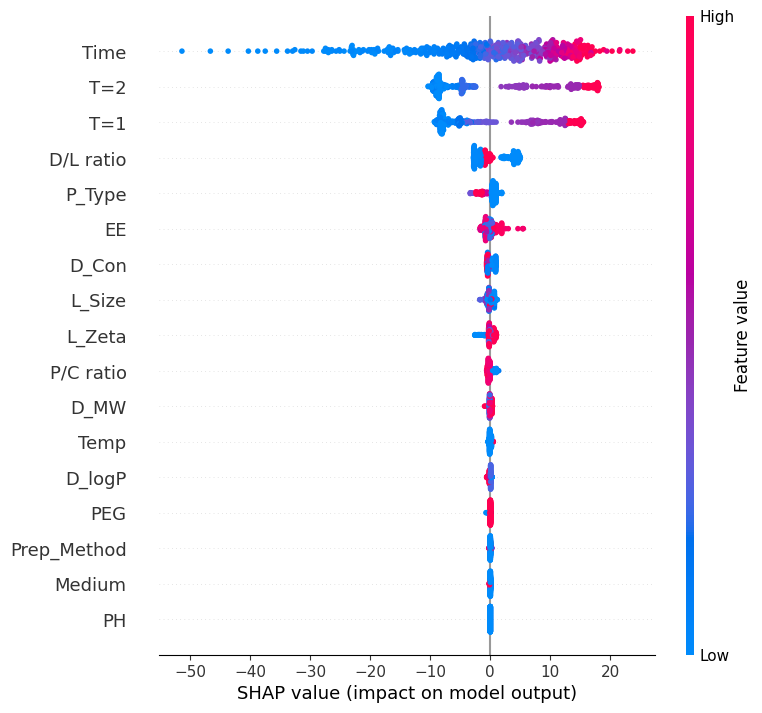

<Figure size 640x480 with 0 Axes>

In [13]:
shap.plots.beeswarm(shap_values, max_display=20)
plt.savefig('ArticleFigures/beeswarm', dpi=600, format = 'png', transparent=True, bbox_inches='tight')

Global bar plot

Passing a matrix of SHAP values to the bar plot function creates a global feature importance plot, where the global importance of each feature is taken to be the mean absolute value for that feature over all the given samples.

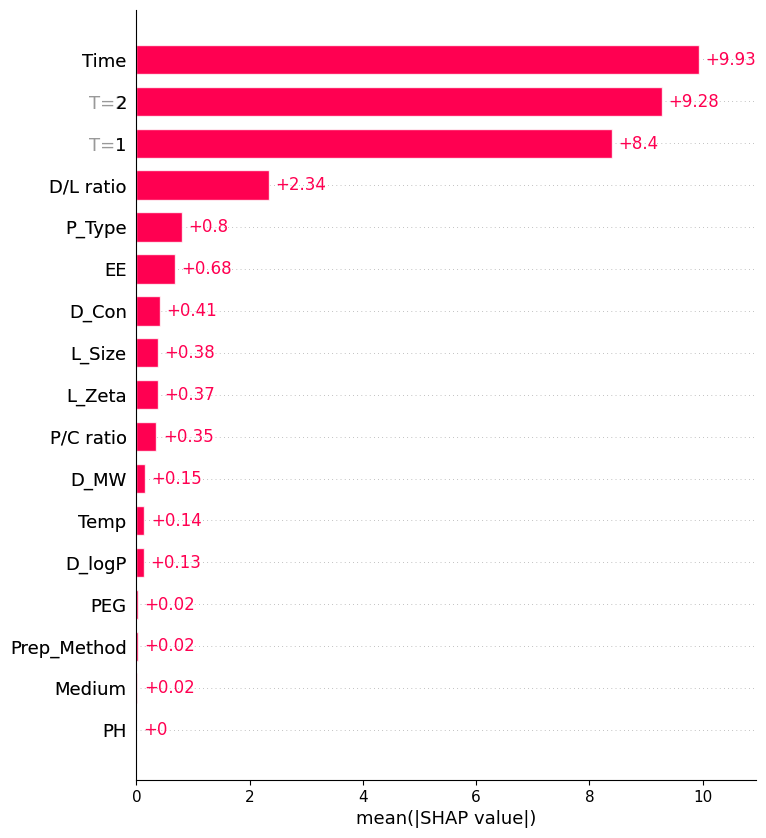

In [21]:
shap.plots.bar(shap_values, max_display=17)

Local bar plot

Passing a row of SHAP values to the bar plot function creates a local feature importance plot, where the bars are the SHAP values for each feature. Note that the feature values are show in gray to the left of the feature names.

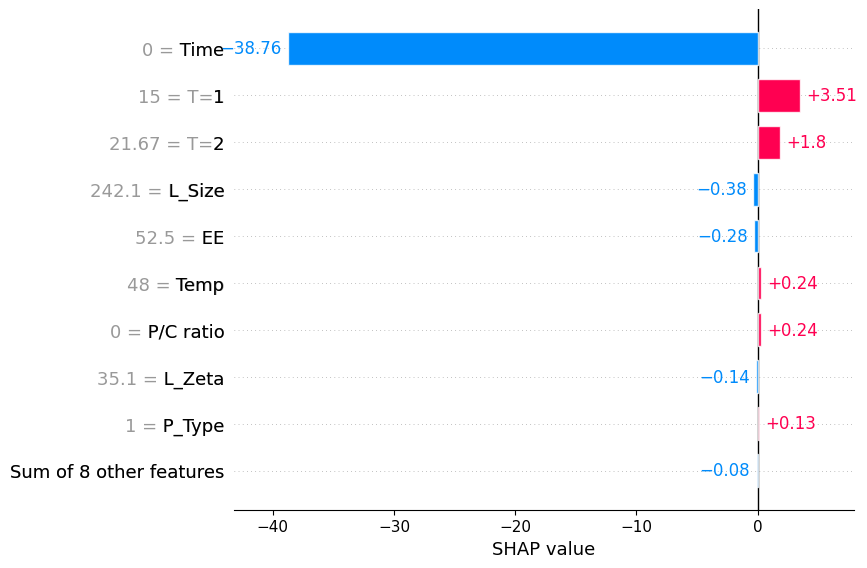

In [22]:
shap.plots.bar(shap_values[0])